In [ ]:
!pip install wandb

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from transformers import ViTForImageClassification, ViTFeatureExtractor
from tqdm import tqdm

In [ ]:
# Constants
BATCH_SIZE = 128  # Increased to utilize 24 GB VRAM
NUM_EPOCHS = 10
NUM_CLASSES = 10
LEARNING_RATE = 1e-4

In [ ]:
# Transformations for CIFAR-10
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT requires 224x224 images
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Load pretrained ViT model
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')
model.classifier = nn.Linear(model.classifier.in_features, NUM_CLASSES)

# Freeze initial layers (encoder layers)
for name, param in model.vit.named_parameters():
    if 'encoder.layer' in name and int(name.split('.')[2]) < 8:
        param.requires_grad = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()  # Mixed-precision training


In [ ]:
# Initialize wandb
import wandb
wandb.init(project="mi_proj2_vit", config={
    "learning_rate": LEARNING_RATE,
    "epochs": NUM_EPOCHS,
    "batch_size": BATCH_SIZE
})

# Set wandb config
config = wandb.config

wandb: Currently logged in as: adiasija10. Use `wandb login --relogin` to force relogin


In [ ]:
# Training function
def train(model, dataloader, criterion, optimizer, scaler):
    model.train()
    running_loss = 0.0
    progress = tqdm(dataloader, desc="Training", leave=False)
    for images, labels in progress:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images).logits
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        progress.set_postfix(loss=f'{running_loss / len(dataloader.dataset):.4f}')

    epoch_loss = running_loss / len(dataloader.dataset)
    wandb.log({"train_loss": epoch_loss })
    return epoch_loss

# Evaluation function
def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    progress = tqdm(dataloader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for images, labels in progress:
            images, labels = images.to(device), labels.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(images).logits
                loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            progress.set_postfix(loss=f'{running_loss / len(dataloader.dataset):.4f}', accuracy=f'{correct / total:.4f}')

    epoch_loss = running_loss / len(dataloader.dataset)
    accuracy = correct / total
    wandb.log({"val_loss": epoch_loss, "val_accuracy": accuracy})
    return epoch_loss, accuracy



In [ ]:

# Fine-tuning loop
for epoch in range(NUM_EPOCHS):
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
    train_loss = train(model, train_loader, criterion, optimizer, scaler)
    val_loss, val_accuracy = evaluate(model, test_loader, criterion)
    print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Save the fine-tuned model
torch.save(model.state_dict(), 'fine_tuned_vit_cifar10.pth')

Epoch 1/10


Training:   0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Train Loss: 0.2990, Val Loss: 0.0869, Val Accuracy: 0.9795
Epoch 2/10


Train Loss: 0.0449, Val Loss: 0.0700, Val Accuracy: 0.9818
Epoch 3/10


Train Loss: 0.0222, Val Loss: 0.0711, Val Accuracy: 0.9803
Epoch 4/10


Train Loss: 0.0129, Val Loss: 0.0747, Val Accuracy: 0.9820
Epoch 5/10


Train Loss: 0.0107, Val Loss: 0.0813, Val Accuracy: 0.9793
Epoch 6/10


Train Loss: 0.0067, Val Loss: 0.0868, Val Accuracy: 0.9813
Epoch 7/10


Train Loss: 0.0104, Val Loss: 0.0812, Val Accuracy: 0.9803
Epoch 8/10


Train Loss: 0.0069, Val Loss: 0.0947, Val Accuracy: 0.9791
Epoch 9/10


Train Loss: 0.0060, Val Loss: 0.1297, Val Accuracy: 0.9719
Epoch 10/10


Train Loss: 0.0066, Val Loss: 0.0940, Val Accuracy: 0.9791


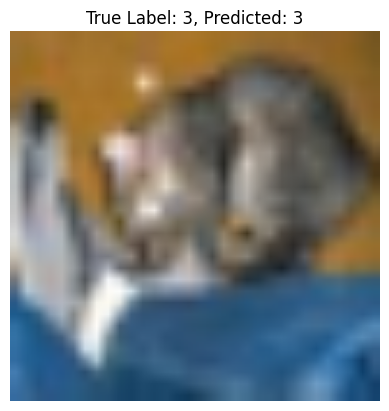

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize a test sample
def visualize_sample(model, dataloader):
    model.eval()
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images).logits
        _, predicted = torch.max(outputs, 1)

    # Convert to CPU for visualization
    image = images[0].cpu().numpy().transpose((1, 2, 0))
    label = labels[0].cpu().item()
    pred = predicted[0].cpu().item()

    # Unnormalize for visualization
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    image = std * image + mean
    image = np.clip(image, 0, 1)

    # Plot the image
    plt.imshow(image)
    plt.title(f'True Label: {label}, Predicted: {pred}')
    plt.axis('off')
    plt.show()

# Call the visualization function
visualize_sample(model, test_loader)
